<img align="center" style="max-width: 1000px" src="https://github.com/HSG-AIML/LabGSERM/blob/main/lab_04/banner.png?raw=1">

<img align="right" style="max-width: 200px; height: auto" src="https://github.com/HSG-AIML/LabGSERM/blob/main/lab_04/hsg_logo.png?raw=1">

##  Lab 04 - "Artificial Neural Networks (ANNs)"

GSERM'21 course "Deep Learning: Fundamentals and Applications", University of St. Gallen

The lab environment of the "Deep Learning: Fundamentals and Applications" GSERM course at the University of St. Gallen (HSG) is based on Jupyter Notebooks (https://jupyter.org), which allow to perform a variety of statistical evaluations and data analyses.

In this lab, we will learn how to implement, train, and apply our first **Artificial Neural Network (ANN)** using a Python library named `PyTorch`. The `PyTorch` library is an open-source machine learning library for Python, used for a variety of applications such as image classification and natural language processing. We will use the implemented neural network to learn to again classify images of fashion articles from the **Fashion-MNIST** dataset.

The figure below illustrates a high-level view of the machine learning process we aim to establish in this lab:

<img align="center" style="max-width: 700px" src="https://github.com/HSG-AIML/LabGSERM/blob/main/lab_04/classification.png?raw=1">

As always, pls. don't hesitate to ask all your questions either during the lab, post them in our CANVAS (StudyNet) forum (https://learning.unisg.ch), or send us an email (using the course email).

## 1. Lab Objectives:

After today's lab, you should be able to:

> 1. Understand the basic concepts, intuitions and major building blocks of **Artificial Neural Networks (ANNs)**.
> 2. Know how to use Python's **PyTorch library** to train and evaluate neural network based models.
> 3. Understand how to apply neural networks to **classify images** of handwritten digits.
> 4. Know how to **interpret the detection results** of the network as well as its **reconstruction loss**.

Before we start let's watch a motivational video:

In [1]:
from IPython.display import YouTubeVideo
# Official Intro | GTC 2017 | I AM AI"
# YouTubeVideo('SUNPrR4o5ZA', width=800, height=400)

## 2. Setup of the Jupyter Notebook Environment

Similar to the previous labs, we need to import a couple of Python libraries that allow for data analysis and data visualization. We will mostly use the `PyTorch`, `Numpy`, `Scikit-Learn`, `Matplotlib` and the `Seaborn` and a few utility libraries throughout this lab:

In [2]:
# import standard python libraries
import os, urllib, io
from datetime import datetime
import numpy as np

Import the Python machine / deep learning libraries:

In [3]:
# import the PyTorch deep learning libary
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim

Import the sklearn classification metrics:

In [4]:
# import sklearn classification evaluation library
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

Import Python plotting libraries:

In [5]:
# import matplotlib, seaborn, and PIL data visualization libary
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

Enable notebook matplotlib inline plotting:

In [6]:
%matplotlib inline

Create a structure of notebook sub-directories inside of the current **working directory** to store (1) the data, (2) the results, as well as (3) the trained neural network models:

In [7]:
# create the data sub-directory
data_directory = './data'
if not os.path.exists(data_directory): os.makedirs(data_directory)

# create the models sub-directory
models_directory = './models'
if not os.path.exists(models_directory): os.makedirs(models_directory) 

Set a random `seed` value to obtain reproducable results:

In [8]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU

Google Colab provides the use of free GPUs for running notebooks. However, if you just execute this notebook as is, it will use your device's CPU. To run the lab on a GPU, got to `Runtime` > `Change runtime type` and set the Runtime type to `GPU` in the drop-down. Running this lab on a CPU is fine, but you will find that GPU computing is faster. *CUDA* indicates that the lab is being run on GPU.

Enable GPU computing by setting the device flag and init a CUDA seed:

In [9]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cpu computation enabled


Let's determine if we have access to a GPU provided by e.g. `Google's Colab` environment:

In [10]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


## 3. Dataset Download and Data Assessment

The **Fashion-MNIST database** is a large database of Zalando articles that is commonly used for training various image processing systems. The database is widely used for training and testing in the field of machine learning. Let's have a brief look into a couple of sample images contained in the dataset:

<img align="center" style="max-width: 700px; height: 300px" src="https://github.com/HSG-AIML/LabGSERM/blob/main/lab_04/FashionMNIST.png?raw=1">

Source: https://www.kaggle.com/c/insar-fashion-mnist-challenge

Further details on the dataset can be obtained via Zalando research's [github page](https://github.com/zalandoresearch/fashion-mnist).

The **Fashion-MNIST database** is an image dataset of Zalando's article images, consisting of in total 70,000 images.

The dataset is divided into a set of **60,000 training examples** and a set of **10,000 evaluation examples**. Each example is a **28x28 grayscale image**, associated with a **label from 10 classes**. Zalando created this dataset with the intention of providing a replacement for the popular **MNIST** handwritten digits dataset. It is a useful addition as it is a bit more complex, but still very easy to use. It shares the same image size and train/test split structure as MNIST, and can therefore be used as a drop-in replacement. It requires minimal efforts on preprocessing and formatting the distinct images.

Let's download, transform and inspect the training images of the dataset. Therefore, let's first define the directory in which we aim to store the training data:

In [11]:
train_path = data_directory + '/train_fashion_mnist'

Now, let's download the training data accordingly:

In [12]:
# define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# download and transform training images
fashion_mnist_train_data = torchvision.datasets.FashionMNIST(root=train_path, train=True, transform=transf, download=True)

Verify the number of training images downloaded:

In [13]:
# determine the number of training data images
len(fashion_mnist_train_data)

60000

Furthermore, let's inspect a couple of the downloaded training images:

In [14]:
# select and set a (random) image id
image_id = 3000

# retrieve image exhibiting the image id
fashion_mnist_train_data[image_id]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0039, 0.0039, 0.0000, 0.0000, 0.4706, 0.5137, 0.3569, 0.5765,
           0.1176, 0.0000, 0.0000, 0.0039, 0.0039, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0118,
           0.0000, 0.0000, 0.0000, 0.0000, 0.9843, 0.7804, 0.6745, 0.7647,
           0.5961, 0.0000, 0.0000, 0.0000, 0.0000, 0.0118, 0.0039, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.1686, 0.4863, 0.7569, 0.6510, 0.9373, 1.0000, 0.8471,
           0.6745, 0.8941, 0.4941, 0.2392, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3765,
           0.6549, 0.6078, 0.6235, 0.6706, 0.6980, 0.8275, 0.8431, 0.8235,
           0.7686, 0.7412, 0.6196, 0.6431, 

Ok, that doesn't seem right :). Let's now seperate the image from its label information:

In [15]:
fashion_mnist_train_image, fashion_mnist_train_label = fashion_mnist_train_data[image_id]

We can verify the label that our selected image has:

In [16]:
fashion_mnist_train_label

6

Ok, we know that the numerical label is 6. Each image is associated with a label from 0 to 9, and this number represents one of the fashion items. So what does 6 mean? Is 6 a bag? A pullover? The order of the classes can be found on Zalando research's [github page](https://github.com/zalandoresearch/fashion-mnist). We need to map each numerical label to its fashion item, which will be useful throughout the lab:

In [17]:
fashion_classes = {0: 'T-shirt/top',
                    1: 'Trouser',
                    2: 'Pullover',
                    3: 'Dress',
                    4: 'Coat',
                    5: 'Sandal',
                    6: 'Shirt',
                    7: 'Sneaker',
                    8: 'Bag',
                    9: 'Ankle boot'}

So, we can determine the fashion item that the label represents:

In [18]:
fashion_classes[fashion_mnist_train_label]

'Shirt'

Great, let's now visually inspect our sample image: 

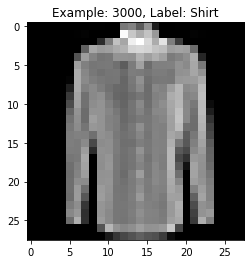

In [19]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title 
plt.title('Example: {}, Label: {}'.format(str(image_id), fashion_classes[fashion_mnist_train_label]))

# plot mnist handwritten digit sample
plt.imshow(trans(fashion_mnist_train_image), cmap='gray')

Fantastic, right? Let's now define the directory in which we aim to store the evaluation data:

In [20]:
eval_path = data_directory + '/eval_fashion_mnist'

And download the evaluation data accordingly:

In [21]:
# define pytorch transformation into tensor format
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# download and transform training images
fashion_mnist_eval_data = torchvision.datasets.FashionMNIST(root=eval_path, train=False, transform=transf, download=True)

Let's also verify the number of evaluation images downloaded:

In [22]:
# determine the number of evaluation data images
len(fashion_mnist_eval_data)

10000

## 4. Neural Network Implementation

In this section we, will implement the architecture of the **neural network** we aim to utilize to learn a model that is capable to classify the 28x28 pixel FashionMNIST images of fashion items. However, before we start the implementation let's briefly revisit the process to be established. The following cartoon provides a birds-eye view:

<img align="center" style="max-width: 1000px" src="https://github.com/HSG-AIML/LabGSERM/blob/main/lab_04/process.png?raw=1">

### 4.1 Implementation of the Neural Network Architecture

The neural network, which we name **'FashionMNISTNet'** consists of three **fully-connected layers** (including an “input layer” and two hidden layers). Furthermore, the **FashionMNISTNet** should encompass the following number of neurons per layer: 100 (layer 1), 50 (layer 2) and 10 (layer 3). Meaning the first layer consists of 100 neurons, the second layer of 50 neurons and third layer of 10 neurons (the number of digit classes we aim to classify.

We will now start implementing the network architecture as a separate Python class. Implementing the network architectures as a **separate class** in Python is good practice in deep learning projects. It will allow us to create and train several instances of the same neural network architecture. This provides us, for example, the opportunity to evaluate different initializations of the network parameters or train models using distinct datasets. 

In [23]:
# implement the MNISTNet network architecture
class FashionMNISTNet(nn.Module):
    
    # define the class constructor
    def __init__(self):
        
        # call super class constructor
        super(FashionMNISTNet, self).__init__()
        
        # specify fully-connected (fc) layer 1 - in 28*28, out 100
        self.linear1 = nn.Linear(28*28, 100, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity 
        
        # specify fc layer 2 - in 100, out 50
        self.linear2 = nn.Linear(100, 50, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU(inplace=True) # the non-linarity
        
        # specify fc layer 3 - in 50, out 10
        self.linear3 = nn.Linear(50, 10) # the linearity W*x+b
        
        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax
        
    # define network forward pass
    def forward(self, images):
        
        # reshape image pixels
        x = images.view(-1, 28*28)
        
        # define fc layer 1 forward pass
        x = self.relu1(self.linear1(x))
        
        # define fc layer 2 forward pass
        x = self.relu2(self.linear2(x))
        
        # define layer 3 forward pass
        x = self.logsoftmax(self.linear3(x))
        
        # return forward pass result
        return x

You may have noticed, when reviewing the implementation above, that we applied an additional operator, referred to as **'Softmax'** to the third layer of our neural network.

The **softmax function**, also known as the normalized exponential function, is a function that takes as input a vector of K real numbers, and normalizes it into a probability distribution consisting of K probabilities. 

That is, prior to applying softmax, some vector components could be negative, or greater than one; and might not sum to 1; but after application of the softmax, each component will be in the interval $(0,1)$, and the components will add up to 1, so that they can be interpreted as probabilities. In general, the softmax function $\sigma :\mathbb {R} ^{K}\to \mathbb {R} ^{K}$ is defined by the formula:

<center> $\sigma (\mathbf {z} )_{i}=\ln ({e^{z_{i}} / \sum _{j=1}^{K}e^{z_{j}}})$ </center>

for $i = 1, …, K$ and ${\mathbf {z}}=(z_{1},\ldots ,z_{K})\in \mathbb {R} ^{K}$ (Source: https://en.wikipedia.org/wiki/Softmax_function ). 

Let's have a look at the simplified three-class example below. The scores of the distinct predicted classes $c_i$ are computed from the forward propagation of the network. We then take the softmax and obtain the probabilities as shown:

<img align="center" style="max-width: 800px" src="https://github.com/HSG-AIML/LabGSERM/blob/main/lab_04/softmax.png?raw=1">

The output of the softmax describes the probability (or if you may, the confidence) of the neural network that a particular sample belongs to a certain class. Thus, for the first example above, the neural network assigns a confidence of 0.49 that it is a 'three', 0.49 that it is a 'four', and 0.03 that it is an 'eight'. The same goes for each of the samples above.

Now, that we have implemented our first neural network we are ready to instantiate a network model to be trained:

In [24]:
model = FashionMNISTNet()

Let's push the initialized `FashionMNISTNet` model to the computing `device` that is enabled:

In [25]:
model = model.to(device)

Let's double check if our model was deployed to the GPU if available:

In [26]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


Once the model is initialized, we can visualize the model structure and review the implemented network architecture by execution of the following cell:

In [27]:
# print the initialized architectures
print('[LOG] FashionMNISTNet architecture:\n\n{}\n'.format(model))

[LOG] FashionMNISTNet architecture:

FashionMNISTNet(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)



Looks like intended? Brilliant! Finally, let's have a look into the number of model parameters that we aim to train in the next steps of the notebook:

In [28]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in model.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained FashionMNISTNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained FashionMNISTNet model parameters: 84060.


Ok, our "simple" FashionMNISTNet model already encompasses an impressive number 84'060 model parameters to be trained.

### 4.2 Specification of the Neural Network Loss Function

Now that we have implemented the **FashionMNISTNet** we are ready to train the network. However, prior to starting the training, we need to define an appropriate loss function. Remember, we aim to train our model to learn a set of model parameters $\theta$ that minimize the classification error of the true class $c^{i}$ of a given handwritten digit image $x^{i}$ and its predicted class $\hat{c}^{i} = f_\theta(x^{i})$ as faithfully as possible. 

Thereby, the training objective is to learn a set of optimal model parameters $\theta^*$ that optimize $\arg\min_{\theta} \|C - f_\theta(X)\|$ over all training images in the FashionMNIST dataset. To achieve this optimization objective, one typically minimizes a loss function $\mathcal{L_{\theta}}$ as part of the network training. In this lab we use the **'Negative Log Likelihood (NLL)'** loss, defined by:

<center> $\mathcal{L}^{NLL}_{\theta} (c_i, \hat c_i) = - \frac{1}{N} \sum_{i=1}^N \log (\hat{c}_i) $, </center>

for a set of $n$-FashionMNIST images $x^{i}$, $i=1,...,n$ and their respective predicted class labels $\hat{c}^{i}$. This is summed for all the correct classes. 

Let's have a look at a brief example:

<img align="center" style="max-width: 900px" src="https://github.com/HSG-AIML/LabGSERM/blob/main/lab_04/loss.png?raw=1">

During training the **NLL** loss will penalize models that result in a high classification error between the predicted class labels $\hat{c}^{i}$ and their respective true class label $c^{i}$. Luckily, an implementation of the NLL loss is already available in PyTorch! It can be instantiated "off-the-shelf" via the execution of the following PyTorch command:

In [29]:
# define the optimization criterion / loss function
nll_loss = nn.NLLLoss()

Let's also push the initialized `nll_loss` computation to the computing `device` that is enabled:

In [30]:
nll_loss = nll_loss.to(device)

## 5. Neural Network Model Training

In this section, we will train our neural network model (as implemented in the section above) using the transformed images of fashion items. More specifically, we will have a detailed look into the distinct training steps as well as how to monitor the training progress.

### 5.1. Preparing the Network Training

So far, we have pre-processed the dataset, implemented the ANN and defined the classification error. Let's now start to train a corresponding model for **20 epochs** and a **mini-batch size of 128** FashionMNIST images per batch. This implies that the whole dataset will be fed to the ANN 20 times in chunks of 128 images yielding to **469 mini-batches** (60.000 images / 128 images per mini-batch) per epoch.

In [31]:
# specify the training parameters
num_epochs = 20 # number of training epochs
mini_batch_size = 128 # size of the mini-batches

Based on the loss magnitude of a certain mini-batch PyTorch automatically computes the gradients. But even better, based on the gradient, the library also helps us in the optimization and update of the network parameters $\theta$.

We will use the **Stochastic Gradient Descent (SGD) optimization** and set the learning-rate $l = 0.001$. Each mini-batch step the optimizer will update the model parameters $\theta$ values according to the degree of classification error (the MSE loss).

In [32]:
# define learning rate and optimization strategy
learning_rate = 0.001
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)

Now that we have successfully implemented and defined the three ANN building blocks let's take some time to review the `FashionMNISTNet` model definition as well as the `loss`. Please, read the above code and comments carefully and don't hesitate to let us know any questions you might have.

Furthermore, lets specify and instantiate a corresponding PyTorch data loader that feeds the image tensors to our neural network:

In [33]:
fashion_mnist_train_dataloader = torch.utils.data.DataLoader(fashion_mnist_train_data, batch_size=mini_batch_size, shuffle=True)

### 5.2. Running the Network Training

Finally, we start training the model. The detailed training procedure for each mini-batch is performed as follows: 

>1. do a forward pass through the FashionMNISTNet network, 
>2. compute the negative log likelihood classification error $\mathcal{L}^{NLL}_{\theta}(c^{i};\hat{c}^{i})$, 
>3. do a backward pass through the FashionMNISTNet network, and 
>4. update the parameters of the network $f_\theta(\cdot)$.

To ensure learning while training our ANN model, we will monitor whether the loss decreases with progressing training. Therefore, we obtain and evaluate the classification performance of the entire training dataset after each training epoch. Based on this evaluation, we can conclude on the training progress and whether the loss is converging (indicating that the model might not improve any further).

The following elements of the network training code below should be given particular attention:
 
>- `loss.backward()` computes the gradients based on the magnitude of the reconstruction loss,
>- `optimizer.step()` updates the network parameters based on the gradient.

In [34]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
model.train()

# train the MNISTNet model
for epoch in range(num_epochs):
    
    # init collection of mini-batch losses
    train_mini_batch_losses = []
    
    # iterate over all-mini batches
    for i, (images, labels) in enumerate(fashion_mnist_train_dataloader):
        
        # push mini-batch data to computation device
        images = images.to(device)
        labels = labels.to(device)

        # run forward pass through the network
        output = model(images)
        
        # reset graph gradients
        model.zero_grad()
        
        # determine classification loss
        loss = nll_loss(output, labels)
        
        # run backward pass
        loss.backward()
        
        # update network paramaters
        optimizer.step()
        
        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())
    
    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    
    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
    
    # set filename of actual model
    model_name = 'fashion_mnist_model_epoch_{}.pth'.format(str(epoch))

    # save current model to GDrive models directory
    torch.save(model.state_dict(), os.path.join(models_directory, model_name))
    
    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

[LOG 20210622-10:02:36] epoch: 0 train-loss: 2.2857290346231034
[LOG 20210622-10:02:42] epoch: 1 train-loss: 2.2357224528469257
[LOG 20210622-10:02:48] epoch: 2 train-loss: 2.1734778001618538
[LOG 20210622-10:02:54] epoch: 3 train-loss: 2.087562035904256
[LOG 20210622-10:03:00] epoch: 4 train-loss: 1.9711277525562214
[LOG 20210622-10:03:05] epoch: 5 train-loss: 1.8301217098480094
[LOG 20210622-10:03:11] epoch: 6 train-loss: 1.6801324554089545
[LOG 20210622-10:03:17] epoch: 7 train-loss: 1.5353414501462663
[LOG 20210622-10:03:23] epoch: 8 train-loss: 1.4042014244522876
[LOG 20210622-10:03:29] epoch: 9 train-loss: 1.2910740835580237
[LOG 20210622-10:03:35] epoch: 10 train-loss: 1.1974204188979256
[LOG 20210622-10:03:41] epoch: 11 train-loss: 1.1212202079260527
[LOG 20210622-10:03:46] epoch: 12 train-loss: 1.0593361269944765
[LOG 20210622-10:03:53] epoch: 13 train-loss: 1.0089575866900526
[LOG 20210622-10:03:59] epoch: 14 train-loss: 0.9674804366982059
[LOG 20210622-10:04:05] epoch: 15 tr

Upon successfull training let's visualize and inspect the training loss per epoch:

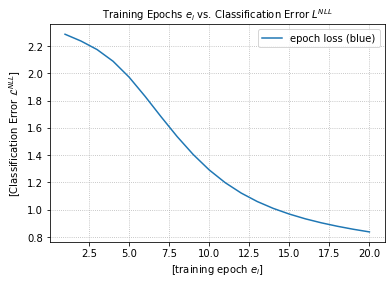

In [35]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

Ok, fantastic. The training error is nicely going down. We could train the network a couple more epochs until the error converges. But let's stay with the 20 training epochs for now and continue with evaluating our trained model.

## 6. Neural Network Model Evaluation

Before evaluating our model let's load the best performing model. Remember, that we stored a snapshot of the model after each training epoch to our local model directory. We will now load the last snapshot saved.

In [36]:
# restore pre-trained model snapshot
best_model_name = 'https://raw.githubusercontent.com/HSG-AIML/LabGSERM/master/lab_04/models/fashion_mnist_model_epoch_19.pth'

# read stored model from the remote location
model_bytes = urllib.request.urlopen(best_model_name)

# load model tensor from io.BytesIO object
model_buffer = io.BytesIO(model_bytes.read())

# init pre-trained model class
best_model = FashionMNISTNet()

# load pre-trained models
best_model.load_state_dict(torch.load(model_buffer, map_location=torch.device('cpu')))

<All keys matched successfully>

Let's inspect if the model was loaded successfully: 

In [37]:
# set model in evaluation mode
best_model.eval()

FashionMNISTNet(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

To evaluate our trained model, we need to feed the FashionMNIST images reserved for evaluation (the images that we didn't use as part of the training process) through the model. Therefore, let's again define a corresponding PyTorch data loader that feeds the image tensors to our neural network: 

In [38]:
fashion_mnist_eval_dataloader = torch.utils.data.DataLoader(fashion_mnist_eval_data, batch_size=10000, shuffle=True)

We will now evaluate the trained model using the same mini-batch approach as we did throughout the network training and derive the mean negative log-likelihood loss of the mini-batches:

In [39]:
# init collection of mini-batch losses
eval_mini_batch_losses = []

# iterate over all-mini batches
for i, (images, labels) in enumerate(fashion_mnist_eval_dataloader):

    # run forward pass through the network
    output = best_model(images)

    # determine classification loss
    loss = nll_loss(output, labels)

    # collect mini-batch reconstruction loss
    eval_mini_batch_losses.append(loss.data.item())

# determine mean min-batch loss of epoch
eval_loss = np.mean(eval_mini_batch_losses)

# print epoch loss
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] eval-loss: {}'.format(str(now), str(eval_loss)))

[LOG 20210622-10:04:30] eval-loss: 0.8420997858047485


Ok, great. The evaluation loss looks in-line with our training loss. Let's now inspect a few sample predictions to get an impression of the model quality. Therefore, we will again pick a random image of our evaluation dataset and retrieve its PyTorch tensor as well as the corresponding label:

In [40]:
# set (random) image id
image_id = 2000

# retrieve image exhibiting the image id
fashion_mnist_eval_image, fashion_mnist_eval_label = fashion_mnist_eval_data[image_id]

Let's now inspect the true class of the image we selected:

In [41]:
fashion_classes[fashion_mnist_eval_label]

'Bag'

Ok, the randomly selected image should contain a bag. Let's inspect the image accordingly:

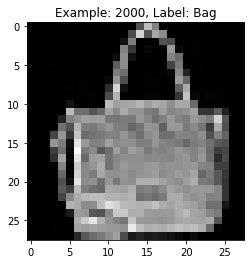

In [42]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title 
plt.title('Example: {}, Label: {}'.format(str(image_id), fashion_classes[fashion_mnist_eval_label]))

# plot mnist handwritten digit sample
plt.imshow(trans(fashion_mnist_eval_image), cmap='gray')

Let's compare the true label with the prediction of our model:

In [43]:
best_model(fashion_mnist_eval_image)

tensor([[-5.5324, -7.3229, -3.6419, -3.8493, -2.9376, -3.1941, -3.4040, -4.9128,
         -0.2235, -4.2964]], grad_fn=<LogSoftmaxBackward>)

We can even determine the likelihood of the most probable class:

In [44]:
most_probable = torch.argmax(best_model(fashion_mnist_eval_image), dim=1).item()
print('Most probable class: {}'.format(most_probable))
print('This class represents the following fashion article: {}'.format(fashion_classes[most_probable]))

Most probable class: 8
This class represents the following fashion article: Bag


Let's now obtain the predictions for all the fashion item images of the evaluation data:

In [45]:
predictions = torch.argmax(best_model(fashion_mnist_eval_data.data.float()), dim=1)

Furthermore, let's obtain the overall classifcation accuracy:

In [46]:
metrics.accuracy_score(fashion_mnist_eval_data.targets, predictions.detach())

0.6712

Let's also inspect the confusion matrix to determine major sources of misclassification:

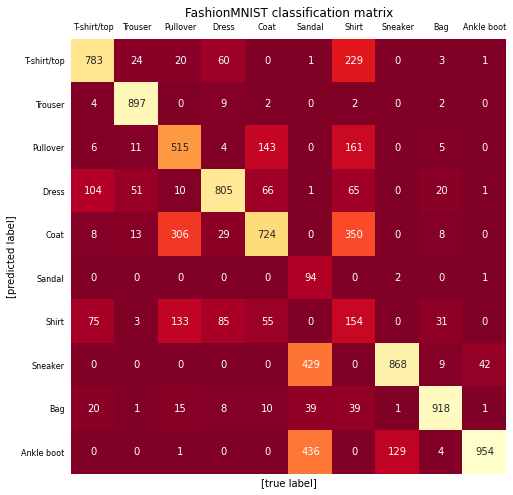

In [47]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(fashion_mnist_eval_data.targets, predictions.detach())

# initialize the plot and define size
plt.figure(figsize=(8, 8))

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=fashion_classes.values(), yticklabels=fashion_classes.values())
plt.tick_params(axis='both', which='major', labelsize=8, labelbottom = False, bottom=False, top = False, left = False, labeltop=True)

# set plot title
plt.title('FashionMNIST classification matrix')

# set axis labels
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

Ok, we can easily see that our current model confuses sandals with either sneakers or ankle boots. However, the inverse does not really hold. The model sometimes confuses sneakers with ankle boots, and only very rarely with sandals. The same holds ankle boots. Our model also has issues distinguishing shirts from coats (and, to a lesser degree, from T-shirts and pullovers).

These mistakes are not very surprising, as these items exhibit a high similarity.

## 7. Lab Summary:

In this lab, a step by step introduction into the **design, implementation, training and evaluation** of neural networks to classify images of fashion items is presented. The code and exercises presented in this lab may serves as a starting point for developing more complex, more deep and tailored **neural networks**.